# Data

In [69]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler

import seaborn as sns
import matplotlib.pyplot as plt

In [107]:
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Dense, Dropout
import seaborn as sns
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score

# Import Libraries and packages from Keras
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint, TensorBoard

In [43]:
pd.set_option('display.max_columns', None)

In [44]:
dfCCO = pd.read_csv('cco_cost_monthly.csv')

In [45]:
dfPYCO = pd.read_csv('pyco_cost_monthly.csv', low_memory=False)

In [46]:
dfXCO = pd.read_csv('xco_cost_monthly.csv')

In [221]:
dfPYCO

,cloud_resource_id,usage_account_id,billing_account_id,provider_code,usage_amount,currency_code,tax,sub_total,total_cost,system_currency_code,conversion_rate,converted_total_cost,product_name,service_code,service_name,product_sku,availability_zone,location_id,usage_type,usage_type_group,cost_type,instance_type,blended_rate,unblended_rate,unblended_cost,category,clock_speed,from_location,to_location,transfer_type,pricing_rate_id,public_ondemand_cost,public_ondemand_rate,pricing_term,pricing_unit,memory,operating_system,vpcu,phsyical_processor,volume_type,storage,storage_class,storage_media,invoice_month
0,arn:aws:ecs:us-east-1:576499398112:task/099f3e...,576499398112,576499398112,aws,0.193333,USD,0,0,0.002458,USD,1,0.002458,Amazon EC2 Container Service,NaN,NaN,F8PQUV5RYP27FPPD,NaN,us-east-1,NaN,NaN,Usage,NaN,0.000000,0.000000,0.002458,Unknown,NaN,NaN,NaN,NaN,1.746118e+09,0.000000,0.000000,NaN,hours,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2020-08-01
1,arn:aws:ecs:us-east-1:576499398112:task/c1dedd...,576499398112,576499398112,aws,0.257778,USD,0,0,0.003280,USD,1,0.003280,Amazon EC2 Container Service,NaN,NaN,F8PQUV5RYP27FPPD,NaN,us-east-1,NaN,NaN,Usage,NaN,0.000000,0.000000,0.003280,Unknown,NaN,NaN,NaN,NaN,1.746118e+09,0.000000,0.000000,NaN,hours,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2020-08-01
2,arn:aws:ecs:us-east-1:576499398112:task/17c16a...,576499398112,576499398112,aws,0.255556,USD,0,0,0.003297,USD,1,0.003297,Amazon EC2 Container Service,NaN,NaN,F8PQUV5RYP27FPPD,NaN,us-east-1,NaN,NaN,Usage,NaN,0.000000,0.000000,0.003297,Unknown,NaN,NaN,NaN,NaN,1.746118e+09,0.000000,0.000000,NaN,hours,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2020-08-01
3,arn:aws:ecs:us-east-1:576499398112:task/97c1a6...,576499398112,576499398112,aws,0.564444,USD,0,0,0.009084,USD,1,0.009084,Amazon EC2 Container Service,NaN,NaN,F8PQUV5RYP27FPPD,NaN,us-east-1,NaN,NaN,Usage,NaN,0.000000,0.000000,0.009084,Unknown,NaN,NaN,NaN,NaN,1.746118e+09,0.000000,0.000000,NaN,hours,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2020-08-01
4,arn:aws:ecs:us-east-1:576499398112:task/becf33...,576499398112,576499398112,aws,0.386667,USD,0,0,0.004938,USD,1,0.004938,Amazon EC2 Container Service,NaN,NaN,F8PQUV5RYP27FPPD,NaN,us-east-1,NaN,NaN,Usage,NaN,0.000000,0.000000,0.004938,Unknown,NaN,NaN,NaN,NaN,1.746118e+09,0.000000,0.000000,NaN,hours,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2020-08-01
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
956579,arn:aws:ecs:us-east-1:576499398112:task/5127fc...,576499398112,576499398112,aws,1.415556,USD,0,0,0.006292,USD,1,0.006292,Amazon EC2 Container Service,AmazonECS,Amazon EC2 Container Service,PBZNQUSEXZUC34C9,NaN,us-east-1,USE1-Fargate-GB-Hours,NaN,Usage,NaN,0.004445,0.004445,0.006292,Compute,NaN,NaN,NaN,NaN,9.493835e+08,0.006292,0.004445,OnDemand,hours,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2020-03-01
956580,arn:aws:ecs:us-east-1:576499398112:task/5da3cc...,576499398112,576499398112,aws,1.415556,USD,0,0,0.006292,USD,1,0.006292,Amazon EC2 Container Service,AmazonECS,Amazon EC2 Container Service,PBZNQUSEXZUC34C9,NaN,us-east-1,USE1-Fargate-GB-Hours,NaN,Usage,NaN,0.004445,0.004445,0.006292,Compute,NaN,NaN,NaN,NaN,9.493835e+08,0.006292,0.004445,OnDemand,hours,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2020-03-01
956581,arn:aws:ecs:us-east-1:576499398112:task/3fa36e...,576499398112,576499398112,aws,1.415556,USD,0,0,0.006292,USD,1,0.006292,Amazon EC2 Container Service,AmazonECS,Amazon EC2 Container Service,PBZNQUSEXZUC34C9,NaN,us-east-1,USE1-Fargate-GB-Hours,NaN,Usage,NaN,0.004445,0.004445,0.006292,Compute,NaN,NaN,NaN,NaN,9.493835e+08,0.006292,0.004445,OnDemand,hours,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2020-03-01
956582,arn:aws:ecs:us-east-1:576499398112:task/535523...,576499398112,576499398112,aws,1.415556,USD,0,0,0.006292,USD,1,0.006292,Amazon EC2 Container Service,AmazonECS,Amazon EC2 Container Service,PBZNQUSEXZUC34C9,NaN,us-east-1,USE1-Fargate-GB-Hours,NaN,Usage,NaN,0.004445,0.004445,

Useful: total_cost, service_name
Maybe: usage_amount, product_name, usage_type, location_id, cost_type, instance_type
Not Useful:cloud_resource_id, usage_account_id, billing_account_id, provider_code, currency_code, tax, sub_total, system_currency_code, conversion_rate, converted_total_cost (redundant), service_code, product_sku, availability_zone, location_id, usage_type_group, 

In [48]:
dfTotal = pd.concat([dfCCO, dfPYCO, dfXCO], axis=0)

In [49]:
# First start the creation of our final dataframe, starting with total monthly cost
def process_dataframe(df, fillna=True):
    """
    Processes a dataFrame from what's initially given to a usable form for our model.
    """
    dfProcessed = df.groupby("invoice_month").agg({"total_cost": "sum"})
    products = dfTotal["product_name"].unique()
    # Loops through all of the unique product names
    for product in products:
        # Grabs the monthly total cost and usage for each product
        df_product_monthly = df.loc[df["product_name"] == product].groupby("invoice_month").agg({"total_cost": "sum", "usage_amount": "sum"}).rename(columns={"total_cost" : product + " cost", "usage_amount": product + " usage"})
        #Concatenates that onto the total dataframe we have
        dfProcessed = pd.concat([dfProcessed, df_product_monthly], axis=1)
        dfProcessed.columns = dfProcessed.columns.str.replace(' ', '_')
        
    if fillna==True:    
        dfProcessed = dfProcessed.fillna(0)
    
    
    return dfProcessed

In [127]:
def selectFeatures(df):
    coli = ["total_cost", "Amazon_Elastic_Compute_Cloud_cost", "Amazon_Relational_Database_Service_cost", "Amazon_Simple_Storage_Service_cost", "Amazon_DocumentDB_(with_MongoDB_compatibility)_cost" , "Amazon_Elastic_File_System_cost"]
    dfVoi = df[coli]
    dfVoi.columns = dfVoi.columns.str.replace('Amazon_', '')
    dfVoi.columns = dfVoi.columns.str.replace('_(with_MongoDB_compatibility)_', '_')
    
    return dfVoi

In [55]:
def testTrainSplit(df, split):
    test = df[:int((len(df))*split)]
    train = df[int((len(df))*split):]
    
    return train, test

In [54]:
def to_supervised (df_for_training, n_future, n_past):
    trainX = []
    trainY = []

    for i in range(n_past, len(df_for_training) - n_future +1):
        trainX.append(df_for_training[i - n_past:i, 0:df_for_training.shape[1]])
        trainY.append(df_for_training[i + n_future - 1:i + n_future, 0])

    trainX, trainY = np.array(trainX), np.array(trainY)

    print('trainX shape == {}.'.format(trainX.shape))
    print('trainY shape == {}.'.format(trainY.shape))
    
    return trainX, trainY


In [182]:
def dataProcess(df, split, n_future, n_past):
    
    dfProcessed = process_dataframe(df, fillna=True)
    #dfVoi = selectFeatures(dfProcessed)
    train, test = testTrainSplit(dfProcessed, split)
    
    ss = StandardScaler()
    trainScaled = ss.fit_transform(train)
    #testScaled = ss.fit_transform(test)

    trainX, trainY = to_supervised(trainScaled, n_future, n_past)
    #testX, testY = to_supervised(testScaled, n_future, n_past)
    
    
    dict = {
        "trainX" : trainX,
        "trainY" : trainY,
        #"testX" : testX,
        #"testY" : testY,
        "ss" : ss
    }

    return dict

In [183]:
dfCCO_processed = process_dataframe(dfCCO, fillna=True)
dfCCO_processed

,total_cost,Elastic_Load_Balancing_cost,Elastic_Load_Balancing_usage,Amazon_Elastic_Compute_Cloud_cost,Amazon_Elastic_Compute_Cloud_usage,Amazon_Simple_Storage_Service_cost,Amazon_Simple_Storage_Service_usage,AWS_Key_Management_Service_cost,AWS_Key_Management_Service_usage,Amazon_Cognito_cost,Amazon_Cognito_usage,AmazonCloudWatch_cost,AmazonCloudWatch_usage,Amazon_EC2_Container_Service_cost,Amazon_EC2_Container_Service_usage,Amazon_QuickSight_cost,Amazon_QuickSight_usage,Amazon_Simple_Queue_Service_cost,Amazon_Simple_Queue_Service_usage,Amazon_Elastic_Container_Service_for_Kubernetes_cost,Amazon_Elastic_Container_Service_for_Kubernetes_usage,AWS_Data_Transfer_cost,AWS_Data_Transfer_usage,AWS_Lambda_cost,AWS_Lambda_usage,Amazon_Elastic_File_System_cost,Amazon_Elastic_File_System_usage,Amazon_Simple_Notification_Service_cost,Amazon_Simple_Notification_Service_usage,AWS_Config_cost,AWS_Config_usage,Amazon_Relational_Database_Service_cost,Amazon_Relational_Database_Service_usage,AWS_Glue_cost,AWS_Glue_usage,AWS_Secrets_Manager_cost,AWS_Secrets_Manager_usage,Amazon_Athena_cost,Amazon_Athena_usage,Amazon_ElastiCache_cost,Amazon_ElastiCache_usage,Amazon_Simple_Email_Service_cost,Amazon_Simple_Email_Service_usage,Amazon_EC2_Container_Registry_(ECR)_cost,Amazon_EC2_Container_Registry_(ECR)_usage,AWS_Support_(Developer)_cost,AWS_Support_(Developer)_usage,AWS_Data_Pipeline_cost,AWS_Data_Pipeline_usage,Amazon_Route_53_cost,Amazon_Route_53_usage,Cyber_Security_Cloud_Managed_Rules_for_AWS_WAF_-API_Gateway/Serverless-_cost,Cyber_Security_Cloud_Managed_Rules_for_AWS_WAF_-API_Gateway/Serverless-_usage,AWS_CloudTrail_cost,AWS_CloudTrail_usage,Amazon_CloudFront_cost,Amazon_CloudFront_usage,AWS_WAF_cost,AWS_WAF_usage,Amazon_API_Gateway_cost,Amazon_API_Gateway_usage,AWS_Cost_Explorer_cost,AWS_Cost_Explorer_usage,Amazon_DynamoDB_cost,Amazon_DynamoDB_usage,AWS_Support_(Business)_cost,AWS_Support_(Business)_usage,Amazon_Kinesis_Firehose_cost,Amazon_Kinesis_Firehose_usage,AWS_Elemental_MediaStore_cost,AWS_Elemental_MediaStore_usage,AWS_Systems_Manager_cost,AWS_Systems_Manager_usage,Amazon_Elasticsearch_Service_cost,Amazon_Elasticsearch_Service_usage,AWS_X-Ray_cost,AWS_X-Ray_usage,AWS_Database_Migration_Service_cost,AWS_Database_Migration_Service_usage,Amazon_SageMaker_cost,Amazon_SageMaker_usage,CloudEndure_Disaster_Recovery_to_AWS_cost,CloudEndure_Disaster_Recovery_to_AWS_usage,Amazon_Lightsail_cost,Amazon_Lightsail_usage,Amazon_DocumentDB_(with_MongoDB_compatibility)_cost,Amazon_DocumentDB_(with_MongoDB_compatibility)_usage,Amazon_Virtual_Private_Cloud_cost,Amazon_Virtual_Private_Cloud_usage,AWS_Step_Functions_cost,AWS_Step_Functions_usage,Amazon_Registrar_cost,Amazon_Registrar_usage,Amazon_Glacier_cost,Amazon_Glacier_usage
2020-08-01,1.717943,0.547634,24.021073,1.147767,24.566741,0.022542,543.011748,0.0,18.0,0.0,2.0,0.00000,0.058898,0.0,6.935227,0.000000,3.930108,0.0,0.0,0.000000,0.000000,0.00,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2020-09-01,37.258579,1.273340,54.133633,20.755028,824.133404,0.021228,2575.908828,0.0,20.0,0.0,1.0,0.00006,6.141876,0.0,9.292604,0.000000,3.955556,0.0,0.0,15.208816,143.688158,0.00,1.0,0.000000,0.000000,0.000106,0.000352,0.000000,1.000000,0.000,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2020-10-01,80.664613,0.122506,6.000797,45.572186,1189.248625,0.013111,761.534243,0.0,9.0,0.0,0.0,0.00000,6.725843,0.0,0.000000,29.817742,4.107527,0.0,6.0,5.138936,49.189360,0.00,1.0,0.000000,4.312500,0.000132,0.001461,0.000000

In [191]:
PYCO_dict=dataProcess(dfPYCO, 0, 1, 3)
XCO_dict=dataProcess(dfXCO, 0, 1, 3)
CCO_dict=dataProcess(dfCCO, 0, 1, 3)


trainX shape == (12, 3, 95).
trainY shape == (12, 1).
trainX shape == (14, 3, 95).
trainY shape == (14, 1).
trainX shape == (5, 3, 95).
trainY shape == (5, 1).


In [192]:
trainX = np.concatenate((PYCO_dict["trainX"], XCO_dict["trainX"], CCO_dict["trainX"]), axis = 0)
trainY = np.concatenate((PYCO_dict["trainY"], XCO_dict["trainY"], CCO_dict["trainY"]), axis = 0)

Model: "sequential_23"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_47 (LSTM)               (None, 3, 16)             7168      
_________________________________________________________________
lstm_48 (LSTM)               (None, 8)                 800       
_________________________________________________________________
dropout_23 (Dropout)         (None, 8)                 0         
_________________________________________________________________
dense_23 (Dense)             (None, 1)                 9         
Total params: 7,977
Trainable params: 7,977
Non-trainable params: 0
_________________________________________________________________
Epoch 1/400
2/2 [==============================] - 3s 764ms/step - loss: 1.0076 - val_loss: 1.1270

Epoch 00001: val_loss improved from inf to 1.12705, saving model to weights.h5
Epoch 2/400
2/2 [==============================] - 0s 35ms/step - loss

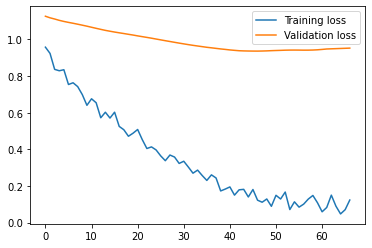

In [217]:
Cost_Predict = build_model(trainX, trainY, 400, 16)

[[ 0]
 [ 1]
 [ 2]
 [ 3]
 [ 4]
 [ 5]
 [ 6]
 [ 7]
 [ 8]
 [ 9]
 [10]
 [11]]


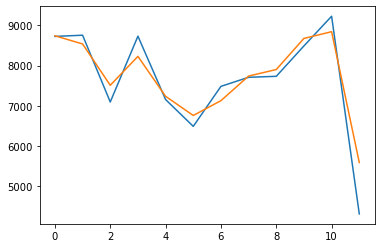

MSE: 209582.1692446513
MAE:  324.87435578023155
R^2: 0.7541028617612487


In [218]:
evaluate_predictions(Cost_Predict, PYCO_dict["trainX"], PYCO_dict["trainY"], PYCO_dict["ss"])

[[0]
 [1]
 [2]
 [3]
 [4]]


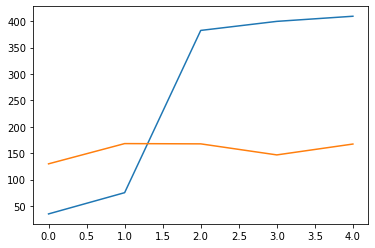

MSE: 37260.97427174162
MAE:  179.49943233648762
R^2: -156.50890273825587


In [219]:
evaluate_predictions(Cost_Predict, CCO_dict["trainX"], CCO_dict["trainY"], CCO_dict["ss"])

[[ 0]
 [ 1]
 [ 2]
 [ 3]
 [ 4]
 [ 5]
 [ 6]
 [ 7]
 [ 8]
 [ 9]
 [10]
 [11]
 [12]
 [13]]


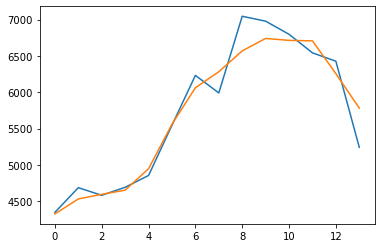

MSE: 56239.83429302107
MAE:  176.56436347912904
R^2: 0.9272426039588384


In [220]:
evaluate_predictions(Cost_Predict, XCO_dict["trainX"], XCO_dict["trainY"], XCO_dict["ss"])

In [216]:
def build_model (trainX, trainY, epoch, bs):
    
    
    model = Sequential()
    model.add(LSTM(16, activation='tanh', input_shape=(trainX.shape[1], trainX.shape[2]), return_sequences=True))
    model.add(LSTM(8, activation='tanh', return_sequences=False))
    model.add(Dropout(0.2))
    model.add(Dense(trainY.shape[1]))

    model.compile(optimizer='adam', loss='mse') #custom loss function, l2/l1 regularization
    model.summary()
    
    es = EarlyStopping(monitor='val_loss', min_delta=1e-10, patience=20, verbose=1)
    rlr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=15, verbose=1)
    mcp = ModelCheckpoint(filepath='weights.h5', monitor='val_loss', verbose=1, save_best_only=True, save_weights_only=True)

    tb = TensorBoard('logs')

    history = model.fit(trainX, trainY, shuffle=True, epochs= epoch, callbacks=[es, rlr, mcp, tb], validation_split=0.2, verbose=1, batch_size= bs)
    plt.plot(history.history['loss'], label='Training loss')
    plt.plot(history.history['val_loss'], label='Validation loss')
    plt.legend()
    
    return model

In [165]:
def evaluate_predictions(model, X, y, ss):
    forecast = model.predict(X)
    
    forecast_copies = np.repeat(forecast, X.shape[2], axis=-1)
    forecast = ss.inverse_transform(forecast_copies)[:,0]
    
    y_copies = np.repeat(y, X.shape[2], axis=-1)
    y = ss.inverse_transform(y_copies)[:,0]

    future_time = [(i) for i in range(np.shape(y)[0])]
    future_time = np.asarray(future_time).reshape(-1,1)
    
    print(future_time)
    
    plt.plot(future_time, y)
    plt.plot(future_time, forecast)
    plt.show()

    print("MSE:", mean_squared_error(forecast, y)) 
    print("MAE: ", mean_absolute_error(forecast, y))
    print("R^2:", r2_score(forecast, y))
    
    return